In [2]:

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# Import from the package

from models.triplet_vae_basic import TripletLossVAE
from utils.data_processing import TrajectoryDataset, prepare_data# train_val_test_split
from utils.diagnostics import plot_latent_space, plot_reconstructions, launch_pyqt_gui
from models.train import train_vae_with_triplet
from utils.latent_space_gui import launch_enhanced_gui

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

import warnings
warnings.filterwarnings('ignore')

Multiprocessing start method: spawn


# 1. Load and prepare data

In [4]:
df = pd.read_parquet('data/training_sims_5_classes.parquet')
#print("Loading data...")


In [5]:
#trajectories, labels, obj_ids = prepare_data('data/training_sims_5_classes.hdf')

# One-liner approach
trajectories = np.array([
    group[['x', 'y','xvel','yvel' ]].values 
    for _, group in df[ (df['time stamp'].between(1100,3000)) ].sort_values(['obj_id_unique', 'time stamp']).groupby('obj_id_unique')
])
        
print(f"Result shape: {trajectories.shape}")

labels = df.groupby('obj_id_unique').first()['dataset_numeric'].values

obj_id_values = df.groupby('obj_id_unique').first().index

print(f"Trajectories shape: {trajectories.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Number of classes: {len(np.unique(labels))}")


Result shape: (50000, 191, 4)
Trajectories shape: (50000, 191, 4)
Labels shape: (50000,)
Number of classes: 5


In [6]:
np.random.seed(42)
## Split data
#(X_train, y_train, ids_train), (X_val, y_val, ids_val), (X_test, y_test, ids_test) = train_val_test_split(
#    trajectories, labels, obj_ids, test_size=0.3, val_size=0.2, 
#)

# Split data
X_train, X_test, y_train, y_test,obj_train, obj_test, = train_test_split(
    trajectories, labels, obj_id_values, test_size=0.3, random_state=42, stratify=labels
)

print(X_train.shape[0])

## Split data
#(X_train, y_train, ids_train), (X_val, y_val, ids_val), (X_test, y_test, ids_test) = train_val_test_split(
#    trajectories, labels, obj_ids, test_size=0.3 #val_size=0.2, 
#)

## Create datasets and dataloaders
train_dataset = TrajectoryDataset(X_train, y_train, obj_train, normalization_type='zero_mean')
#val_dataset = TrajectoryDataset(X_val, y_val, ids_val, normalization_type='zero_mean')
test_dataset = TrajectoryDataset(X_test, y_test, obj_test, normalization_type='zero_mean')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


35000


In [7]:

input_dim = X_train.shape[1] * X_train.shape[2]

# add an additional unlabeled dataset for testing 

In [9]:
tmp = pd.read_parquet('data/example_test_data.parquet')


In [10]:
tmp['color']= 'blue'
tmp['dataset_numeric']= 0 # assign arbitrary class since this is real trajectory data/ not generated from an algo
# One-liner approach
nw_array = np.array([
    group[['x', 'y', 'xvel', 'yvel', ]].values 
    for _, group in tmp.sort_values(['obj_id_unique', 'time stamp']).groupby('obj_id_unique')
])

print(f"Result shape: {nw_array.shape}")
nw_labels = tmp.groupby('obj_id_unique').first()['dataset_numeric'].values


print(f"Trajectories shape: {nw_array.shape}")  # Should be (1500, 200, 4)
print(f"Labels shape: {nw_labels.shape}")

nw_objids = tmp.groupby('obj_id_unique').first().index#.values
nw_color =  tmp.groupby('obj_id_unique').first()['color']



# Now split while maintaining correspondence
X_train_nw, X_test_nw, y_train_nw, y_test_nw, y_train_nw_color, y_test_nw_color,y_train_nw_obj, y_test_nw_obj   = train_test_split(
                                                                nw_array, 
                                                                nw_labels, 
                                                                nw_color,
                                                                nw_objids, # Include color variable in split
                                                                test_size=0.01, 
                                                                random_state=42, 
                                                                stratify=nw_labels
                                                            )

# Create datasets and dataloaders
train_dataset_nw = TrajectoryDataset(X_train_nw, y_train_nw,y_train_nw_obj,  normalization_type='zero_mean')
test_dataset_nw = TrajectoryDataset(X_test_nw, y_test_nw,y_test_nw_obj,  normalization_type='zero_mean')

train_loader_nw = DataLoader(train_dataset_nw, batch_size=32, shuffle=True)
test_loader_nw = DataLoader(test_dataset_nw, batch_size=32, shuffle=False)

Result shape: (214, 191, 4)
Trajectories shape: (214, 191, 4)
Labels shape: (214,)


# 2. Initialize model

In [12]:

model = TripletLossVAE(
    input_dim=input_dim,
    hidden_dim=256,
    latent_dim=50,
    margin=1.0,
    #dropout=0.2
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 486,240


# 3. Train the model

In [24]:
print("\nTraining model...")
metrics = train_vae_with_triplet(
    model, train_loader, val_loader,
    epochs=250,
    triplet_weight=1,
    beta=0.001,
    lr=1e-4
)



Training model...
Epoch 000:
  Train - Total: 0.014446, VAE: 0.005735, Triplet: 0.008711, KL: 0.005093
  Val   - Total: 0.009592, VAE: 0.004966, Triplet: 0.004626, KL: 0.006995
Epoch 020:
  Train - Total: 0.002917, VAE: 0.002616, Triplet: 0.000300, KL: 0.038657
  Val   - Total: 0.002624, VAE: 0.002321, Triplet: 0.000304, KL: 0.039591
Epoch 040:
  Train - Total: 0.002376, VAE: 0.002271, Triplet: 0.000105, KL: 0.050419
  Val   - Total: 0.002159, VAE: 0.001958, Triplet: 0.000201, KL: 0.050865
Epoch 060:
  Train - Total: 0.002196, VAE: 0.002134, Triplet: 0.000062, KL: 0.052117
  Val   - Total: 0.001993, VAE: 0.001798, Triplet: 0.000195, KL: 0.052927
Epoch 080:
  Train - Total: 0.002091, VAE: 0.002059, Triplet: 0.000032, KL: 0.051867
  Val   - Total: 0.001871, VAE: 0.001733, Triplet: 0.000139, KL: 0.052270
Epoch 100:
  Train - Total: 0.002036, VAE: 0.002014, Triplet: 0.000022, KL: 0.051526
  Val   - Total: 0.001802, VAE: 0.001690, Triplet: 0.000112, KL: 0.052075
Epoch 120:
  Train - Total:

## save model

In [26]:
model.eval()
    # Define the path to save the model
PATH = "data/example_model.pth"

# Save the state_dict
torch.save(model.state_dict(), PATH)

# 4. Basic loss plots

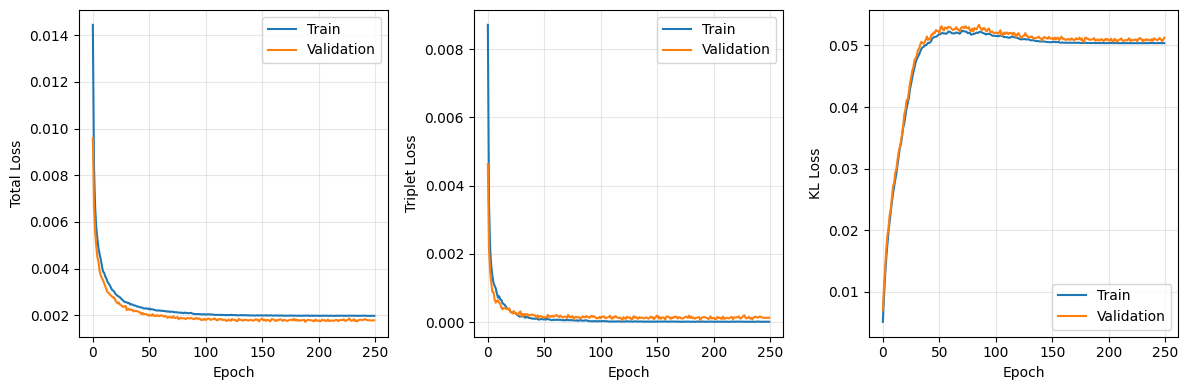

In [28]:

# Plot training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(metrics['train_losses'], label='Train')
plt.plot(metrics['val_losses'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(metrics['triplet_losses'], label='Train')
plt.plot(metrics['val_triplet_losses'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Triplet Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(metrics['kl_losses'], label='Train')
plt.plot(metrics['val_kl_losses'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('KL Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3A: Alternative : read in prior trained model

In [14]:
model.load_state_dict(torch.load("data/triplet_5_classes.pth"))

<All keys matched successfully>

# 5. Visualize latent space


Plotting latent space...
PCA explained variance: [0.40908596 0.23369987]


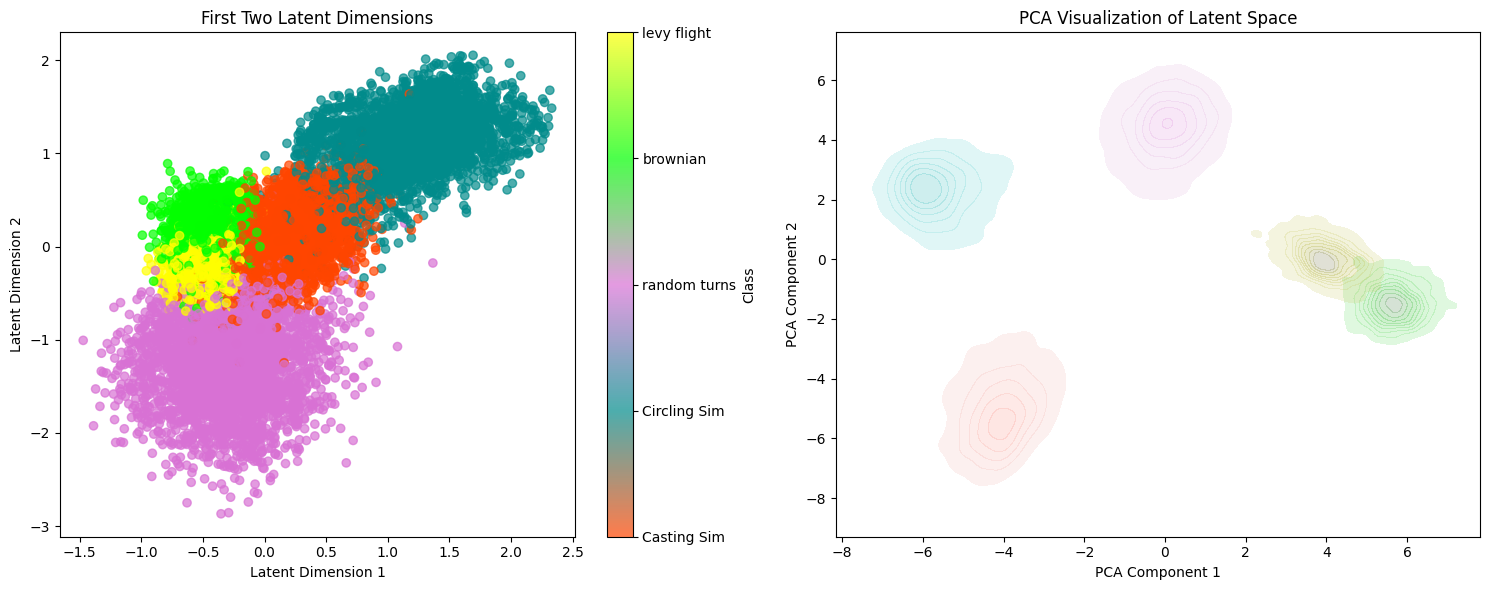

In [16]:
class_labels={
   0: 'Casting Sim', 
    1: 'Circling Sim',
    2:  'random turns',
    3: 'brownian', 
    4:'levy flight',
    #5:'run and tumble'
}

class_colors= {
    0:'orangered',
    1:'darkcyan',
    2: 'orchid',
    3:'lime',
    4:'yellow',
    #5: 'grey',
}


print("\nPlotting latent space...")
latent_vectors, true_labels, latent_pca, obj_ids = plot_latent_space(
    model, test_loader, y_test,
    train_colors=['orangered', 'darkcyan',  'orchid','lime', 'yellow',],                
    reduce='PCA',
    KDE=True,
    class_labels=class_labels,
    path='latent_space.png'
)


# 6. Look at reconstructions


Plotting reconstructions...


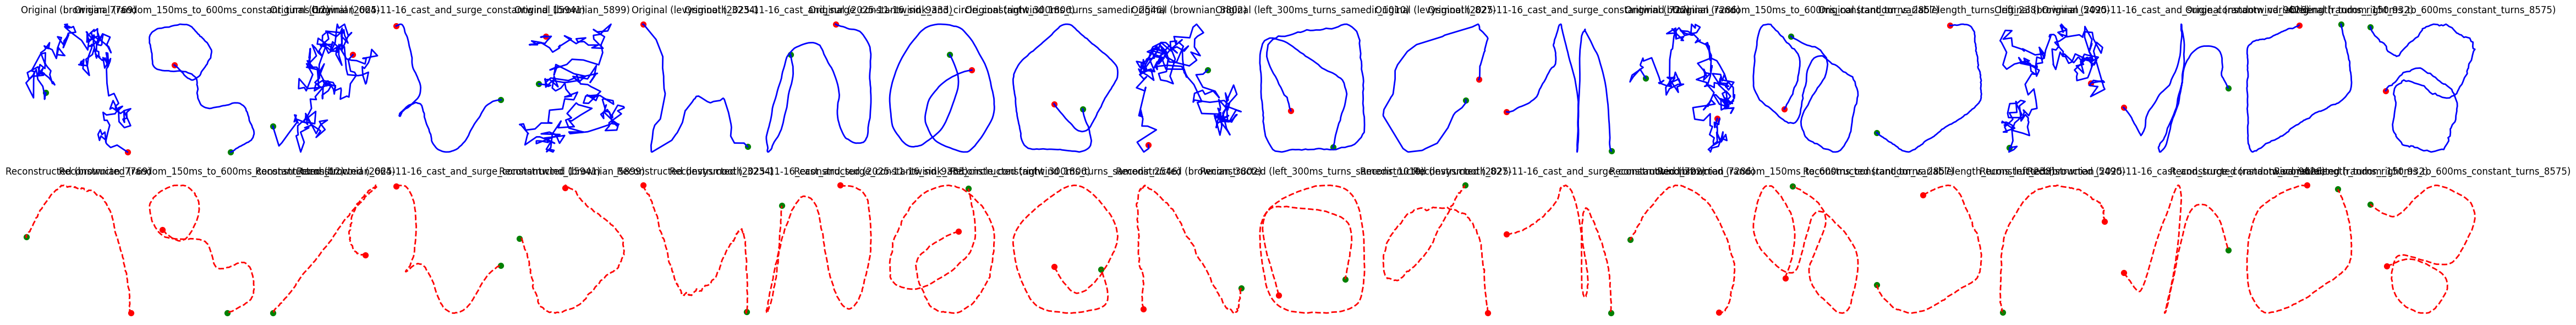

In [18]:
print("\nPlotting reconstructions...")
plot_reconstructions(model, test_loader, n_input_feats=4, num_samples=20, save_path='reconstructions.png')


# 7. Open interactive plotting tool to see generated trajectories from chosen 2D points

In [20]:
# Method 1: Simple launch
manager = launch_enhanced_gui(
    model, train_loader, train_loader_nw,
    y_train, y_train_nw,
    n_features=4, seq_length=191, batch_size=64,
    initial_mode='generate_trajectories')


Launching Enhanced Latent Space Explorer
Preparing data for GUI...
Extracting training data...
Data shape: torch.Size([35000, 764])
Latent vectors shape: (35000, 50)
Labels shape: (35000,)
Training data shape: (35000, 764)
Training latent shape: (35000, 50)
Training labels shape: (35000,)
Extracting test data...
Data shape: torch.Size([211, 764])
Latent vectors shape: (211, 50)
Labels shape: (211,)
Test data shape: (211, 764)
Test latent shape: (211, 50)
Computing PCA...
PCA components shape: (2, 50)
PCA explained variance: [0.49600524 0.20628417]
Total variance explained: 0.702
Training classes: [0 1 2 3 4]
Computing KDEs...
  Class 0: KDE computed with 1000 points
  Class 1: KDE computed with 1000 points
  Class 2: KDE computed with 1000 points
  Class 3: KDE computed with 1000 points
  Class 4: KDE computed with 1000 points
Model input dimension (flattened): 764

✓ GUI data prepared successfully!
  Train samples: 35000
  Test samples: 211
  Number of classes: 5
  PCA dimensions: (3